In [1]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [3]:
df = pd.read_csv("historicals.csv",usecols = ['lead_created_week','lead_vol'])
df = df[:-1]

In [4]:
df['lead_created_week'] = pd.to_datetime(df['lead_created_week'])

In [5]:
df['lead_created_week'].min(), df['lead_created_week'].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2021-03-22 00:00:00'))

In [6]:
df = df.set_index('lead_created_week')
df.index

DatetimeIndex(['2018-01-01', '2018-01-08', '2018-01-15', '2018-01-22',
               '2018-01-29', '2018-02-05', '2018-02-12', '2018-02-19',
               '2018-02-26', '2018-03-05',
               ...
               '2021-01-18', '2021-01-25', '2021-02-01', '2021-02-08',
               '2021-02-15', '2021-02-22', '2021-03-01', '2021-03-08',
               '2021-03-15', '2021-03-22'],
              dtype='datetime64[ns]', name='lead_created_week', length=169, freq=None)

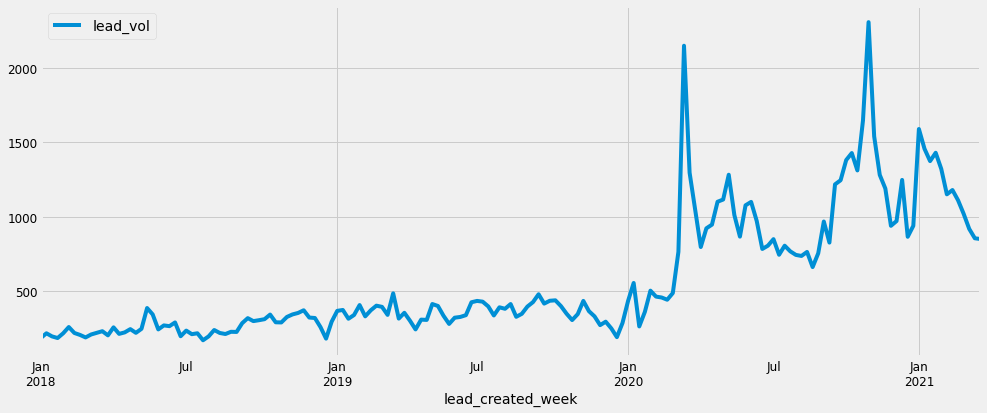

In [7]:
df.plot(figsize=(15, 6))
plt.show()

### Decompose our time series into three distinct components: trend, seasonality, and noise.

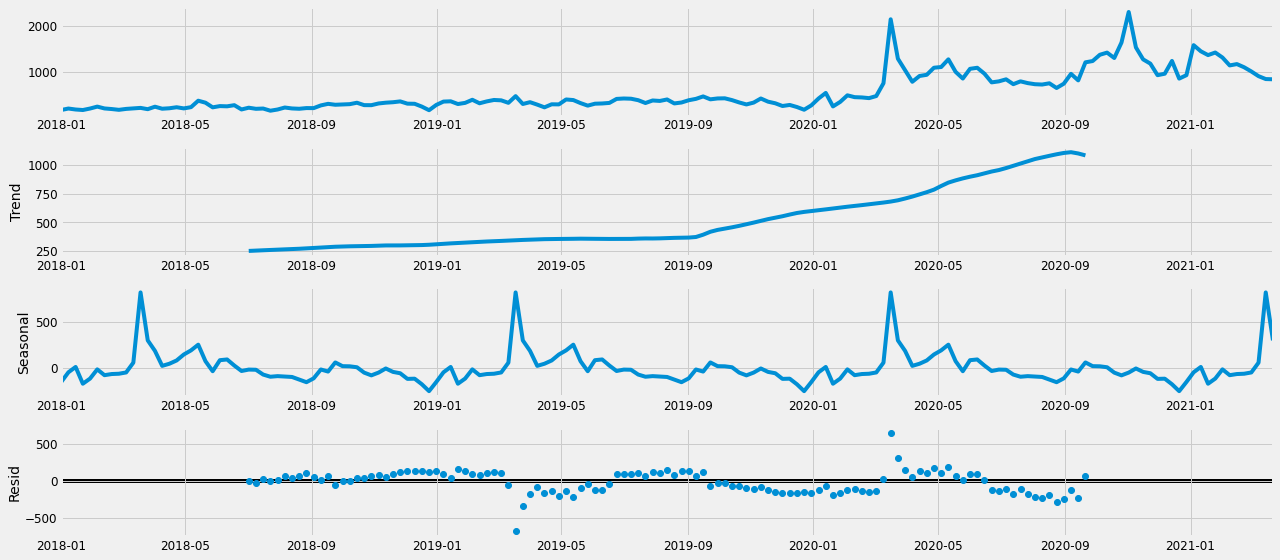

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df, model='additive')
fig = decomposition.plot()
plt.show()

### Check Stationarity
##### Why is it important? Most of the TS models work on the assumption that the TS is stationary

In [43]:
# Dickey-Fuller Test:
# If the ‘Test Statistic’ is less than the ‘Critical Value’, 
# we can reject the null hypothesis and say that the series is stationary. 

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

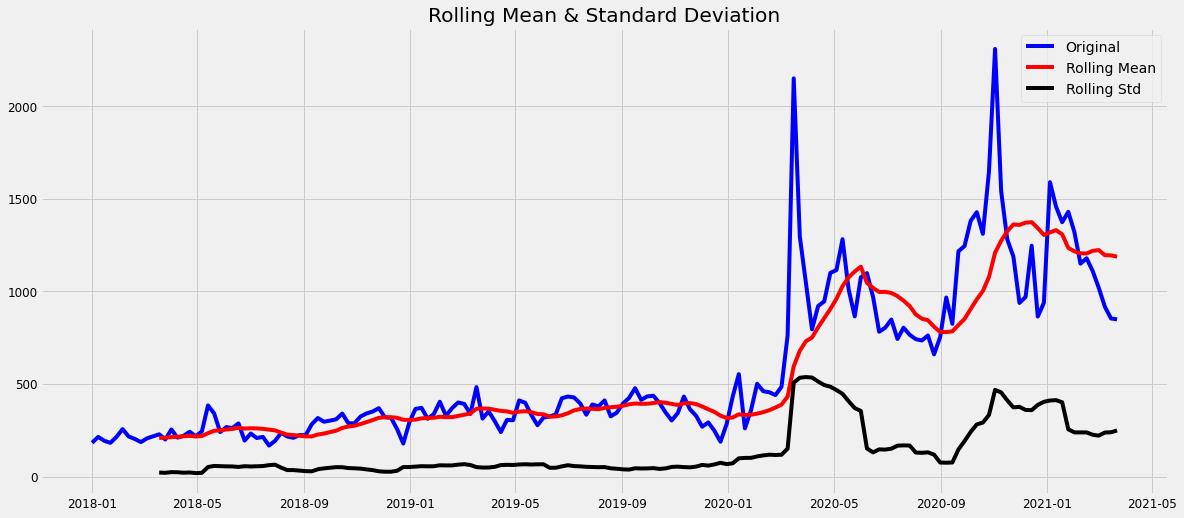

Results of Dickey-Fuller Test:
Test Statistic                  -2.079553
p-value                          0.252815
#Lags Used                       2.000000
Number of Observations Used    166.000000
Critical Value (1%)             -3.470370
Critical Value (5%)             -2.879114
Critical Value (10%)            -2.576139
dtype: float64


In [44]:
test_stationarity(df)

### TimeSeries != Stationary

### Eliminating trend (Log Transform)

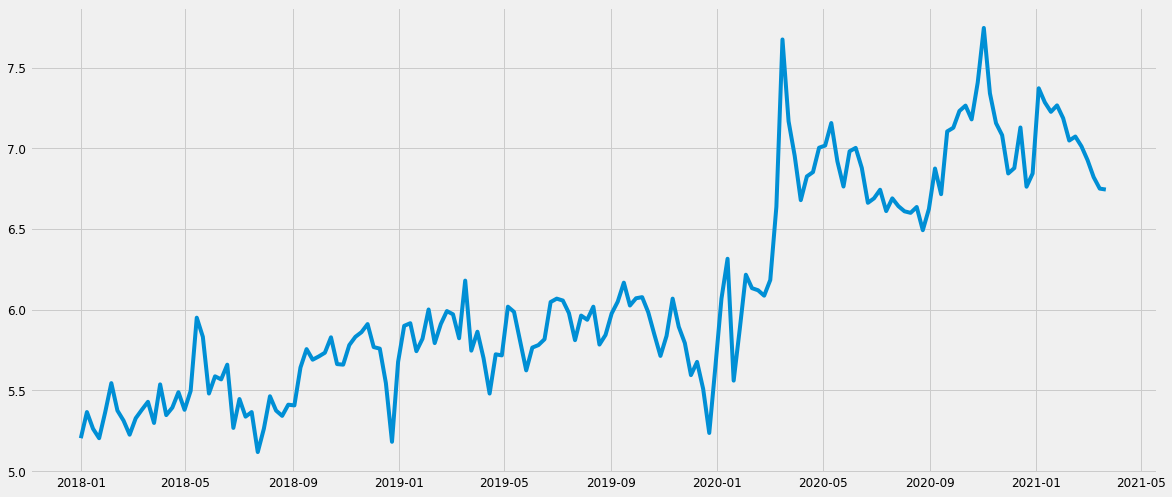

In [45]:
ts_log = np.log(df)
plt.plot(ts_log)

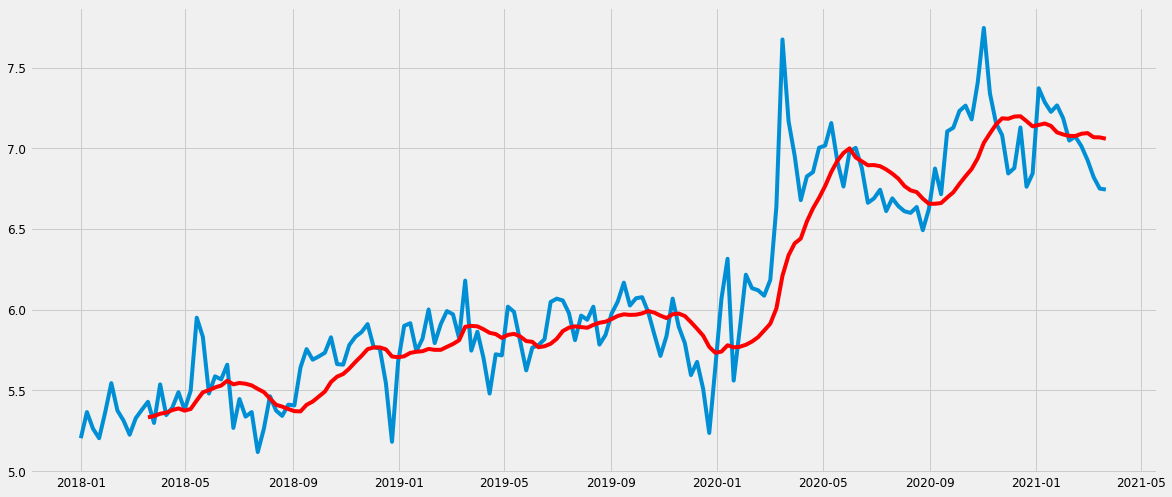

In [46]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [47]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

,lead_vol
lead_created_week,
2018-01-01,NaN
2018-01-08,NaN
2018-01-15,NaN
2018-01-22,NaN
2018-01-29,NaN
2018-02-05,NaN
2018-02-12,NaN
2018-02-19,NaN
2018-02-26,NaN


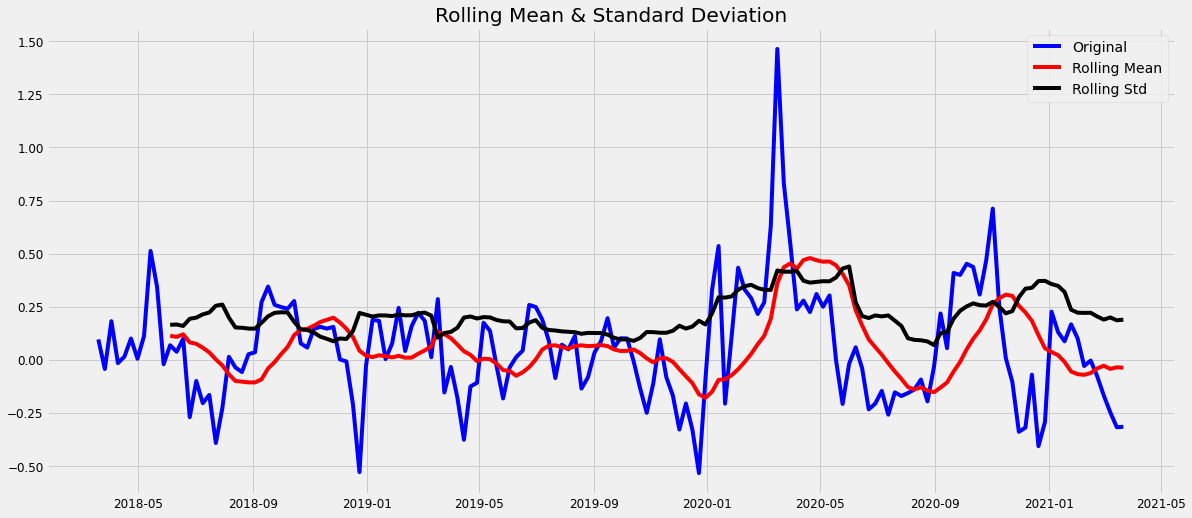

Results of Dickey-Fuller Test:
Test Statistic                  -5.257860
p-value                          0.000007
#Lags Used                       0.000000
Number of Observations Used    157.000000
Critical Value (1%)             -3.472703
Critical Value (5%)             -2.880132
Critical Value (10%)            -2.576683
dtype: float64


In [48]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

##### The test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a stationary series.

## Forecasting

In [49]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [50]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
                continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2684.2102626107453
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2407.39578199643
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2270.8543182397552
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2084.073787992358
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2286.2920521842602
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2209.259268901047
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2091.6662661730766
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2080.1247751325222
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2501.960874402517
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2272.516495199478
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2188.325754825772
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1999.0504035904296
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2214.0278940338144
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2128.4706935137156
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2024.44955141271
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1998.1475151253223
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2224.4920629148883
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2077.915693361215
AR

### Best model  --> ARIMA(1, 1, 1)x(0, 1, 1, 12)12- AIC:1915.7572620246651

In [51]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6635      0.085      7.793      0.000       0.497       0.830
ma.L1         -0.9314      0.058    -16.153      0.000      -1.044      -0.818
ma.S.L12      -1.0500      0.344     -3.052      0.002      -1.724      -0.376
sigma2      3.202e+04   1.34e+04      2.390      0.017    5767.291    5.83e+04


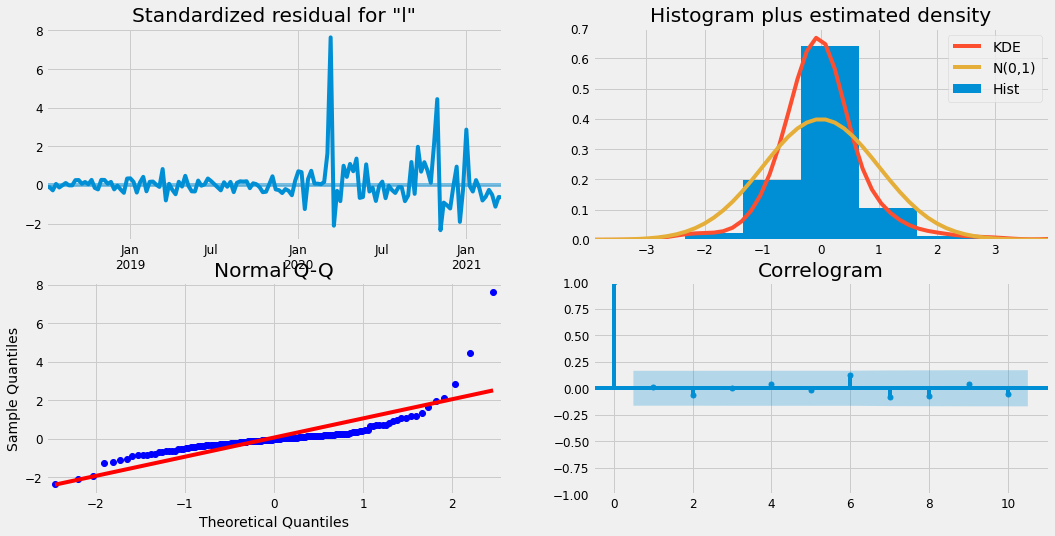

In [52]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

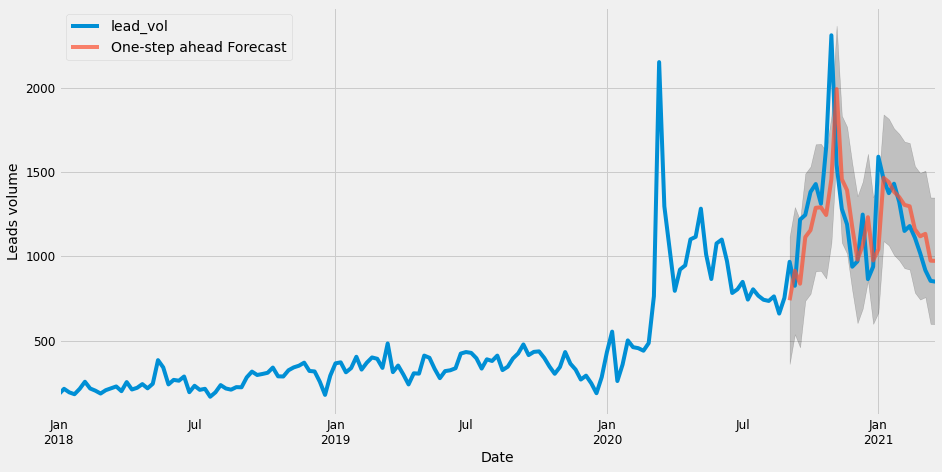

In [53]:
pred = results.get_prediction(start=pd.to_datetime('2020-09-07'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Leads volume')
plt.legend()
plt.show()

In [54]:
y_forecasted = pred.predicted_mean
y_truth = df['2020-09-07':]
mse = ((y_forecasted - y_truth.lead_vol) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 72962.77


In [55]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 270.12


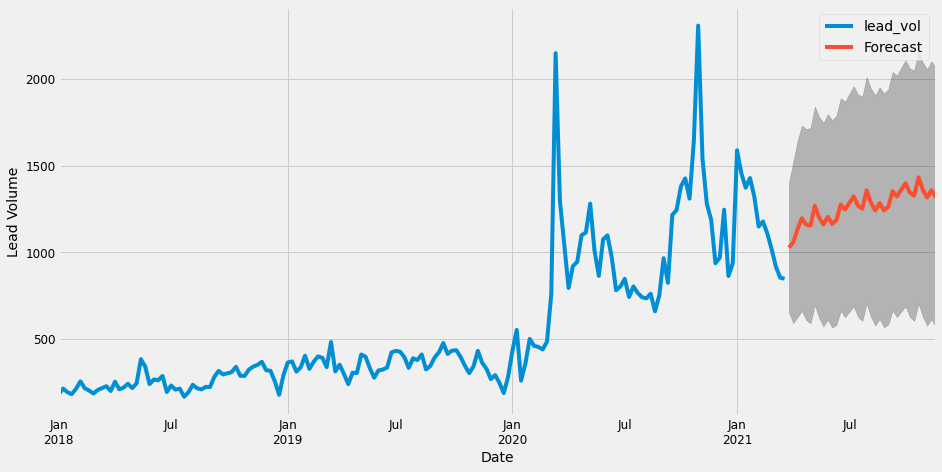

In [56]:
pred_uc = results.get_forecast(steps=35)
pred_ci = pred_uc.conf_int()
ax = df.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Lead Volume')
plt.legend()
plt.show()

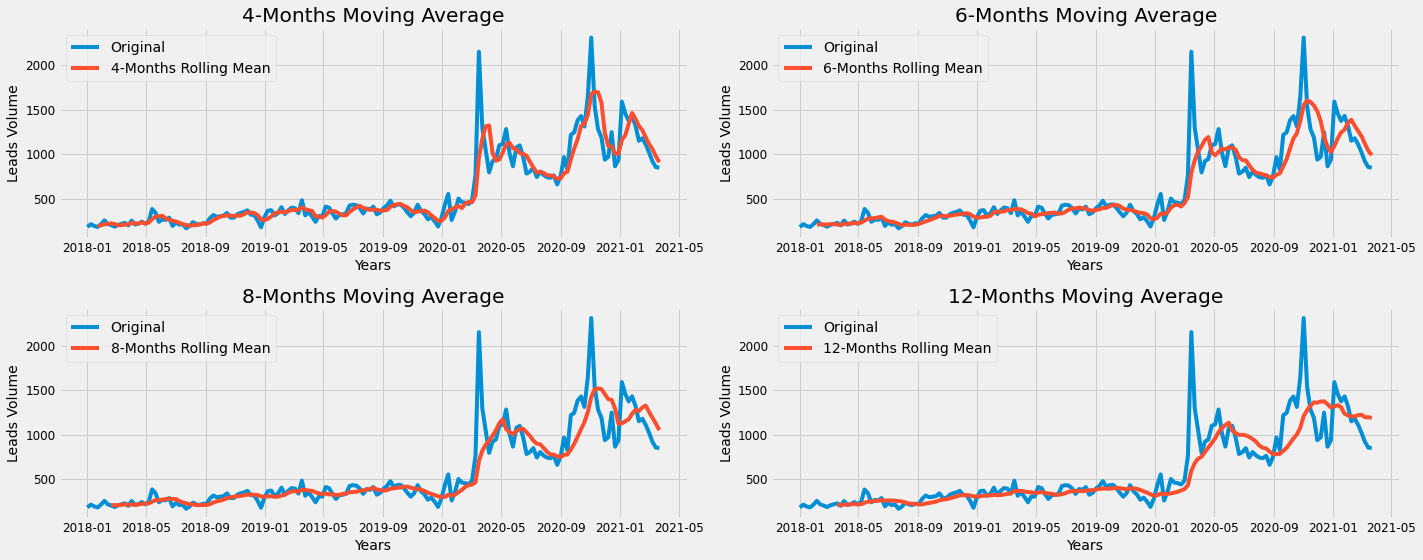

In [60]:
fig, axes = plt.subplots(2, 2, sharey=False, sharex=False)
fig.set_figwidth(20)
fig.set_figheight(8)
axes[0][0].plot(df.index, df.lead_vol, label='Original')
axes[0][0].plot(df.index, df.lead_vol.rolling(window=4).mean(), label='4-Months Rolling Mean')
axes[0][0].set_xlabel("Years")
axes[0][0].set_ylabel("Leads Volume")
axes[0][0].set_title("4-Months Moving Average")
axes[0][0].legend(loc='best')
axes[0][1].plot(df.index, df.lead_vol, label='Original')
axes[0][1].plot(df.index, df.lead_vol.rolling(window=6).mean(), label='6-Months Rolling Mean')
axes[0][1].set_xlabel("Years")
axes[0][1].set_ylabel("Leads Volume")
axes[0][1].set_title("6-Months Moving Average")
axes[0][1].legend(loc='best')
axes[1][0].plot(df.index, df.lead_vol, label='Original')
axes[1][0].plot(df.index, df.lead_vol.rolling(window=8).mean(), label='8-Months Rolling Mean')
axes[1][0].set_xlabel("Years")
axes[1][0].set_ylabel("Leads Volume")
axes[1][0].set_title("8-Months Moving Average")
axes[1][0].legend(loc='best')
axes[1][1].plot(df.index, df.lead_vol, label='Original')
axes[1][1].plot(df.index, df.lead_vol.rolling(window=12).mean(), label='12-Months Rolling Mean')
axes[1][1].set_xlabel("Years")
axes[1][1].set_ylabel("Leads Volume")
axes[1][1].set_title("12-Months Moving Average")
axes[1][1].legend(loc='best')
plt.tight_layout()
plt.show()

# Outliers

In [61]:
## For data
import pandas as pd
import numpy as np## For plotting
import matplotlib.pyplot as plt## For outliers detection
from sklearn import preprocessing, svm## For stationarity test and decomposition
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import seaborn as sns

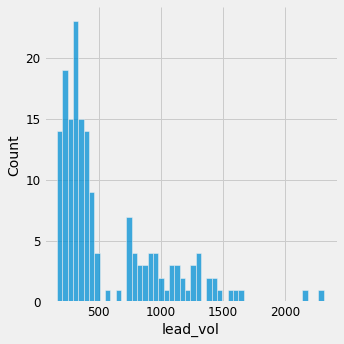

In [62]:
sns.displot(df, x="lead_vol", bins=50)

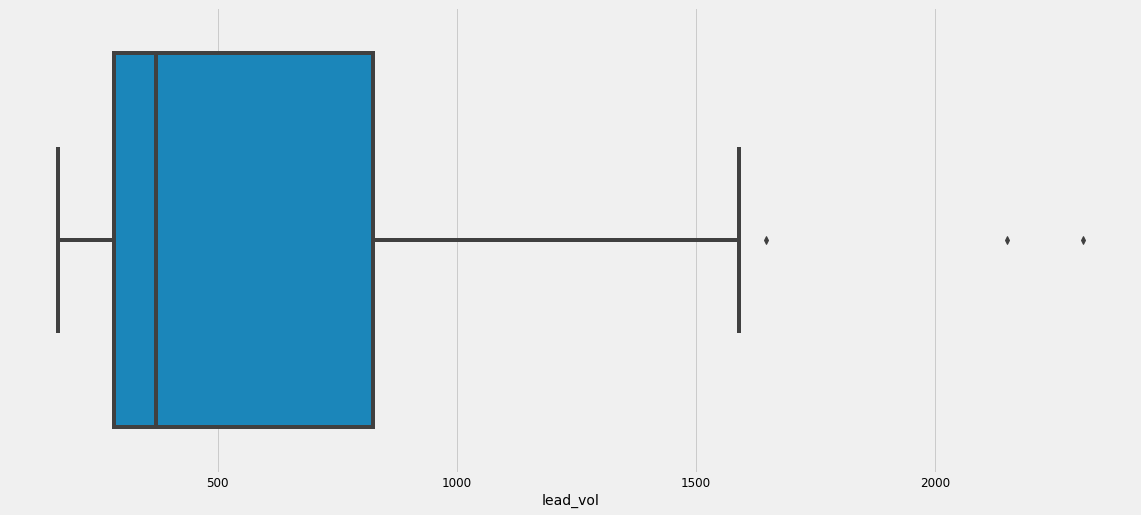

In [63]:
ax = sns.boxplot(x=df["lead_vol"])

In [64]:
'''
Find outliers using sklearn unsupervised support vector machine.
:parameter
    :param ts: pandas Series
    :param perc: float - percentage of outliers to look for
:return
    dtf with raw ts, outlier 1/0 (yes/no), numeric index
'''
def find_outliers(ts, perc=0.01, figsize=(15,5)):
    ## fit svm
    scaler = preprocessing.StandardScaler()
    ts_scaled = scaler.fit_transform(ts.values.reshape(-1,1))
    model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
    model.fit(ts_scaled)    ## dtf output
    dtf_outliers = ts.to_frame(name="ts")
    dtf_outliers["index"] = range(len(ts))
    dtf_outliers["outlier"] = model.predict(ts_scaled)
    dtf_outliers["outlier"] = dtf_outliers["outlier"].apply(lambda
                                              x: 1 if x==-1 else 0)
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.set(title="Outliers detection: found"
           +str(sum(dtf_outliers["outlier"]==1)))
    ax.plot(dtf_outliers["index"], dtf_outliers["ts"],
            color="black")
    ax.scatter(x=dtf_outliers[dtf_outliers["outlier"]==1]["index"],
               y=dtf_outliers[dtf_outliers["outlier"]==1]['ts'],
               color='red')
    ax.grid(True)
    plt.show()
    return dtf_outliers

In [76]:
def remove_outliers(ts, outliers_idx, figsize=(15,5)):
    ts_clean = ts.copy()
    ts_clean.loc[outliers_idx] = np.nan
    ts_clean = ts_clean.interpolate(method="linear")
    ax = ts.plot(figsize=figsize, color="red", alpha=0.5,
         title="Remove outliers", label="original", legend=True)
    ts_clean.plot(ax=ax, grid=True, color="black",
                  label="interpolated", legend=True)
    plt.show()
    return ts_clean

In [72]:
df.reset_index(inplace=True)

In [73]:
df

,lead_created_week,lead_vol
0,2018-01-01,182.0
1,2018-01-08,214.0
2,2018-01-15,193.0
3,2018-01-22,182.0
4,2018-01-29,214.0
...,...,...
164,2021-02-22,1110.0
165,2021-03-01,1019.0
166,2021-03-08,917.0
167,2021-03-15,854.0


In [74]:
ts = df.groupby("lead_created_week")["lead_vol"].sum().rename("lead volume")

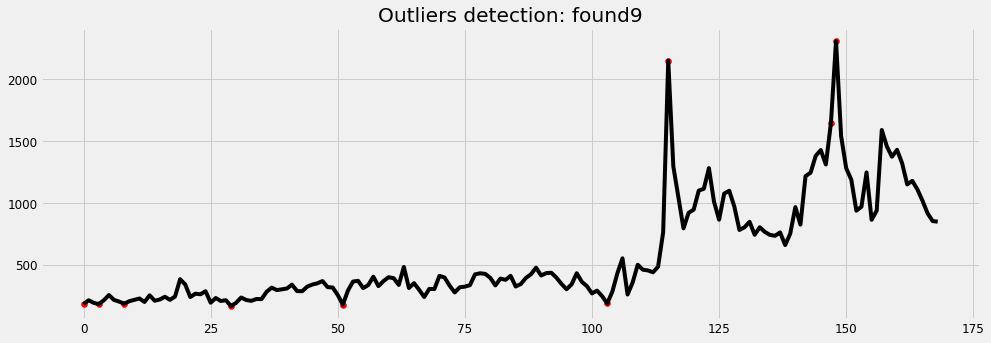

In [75]:
dtf_outliers = find_outliers(ts, perc=0.05)

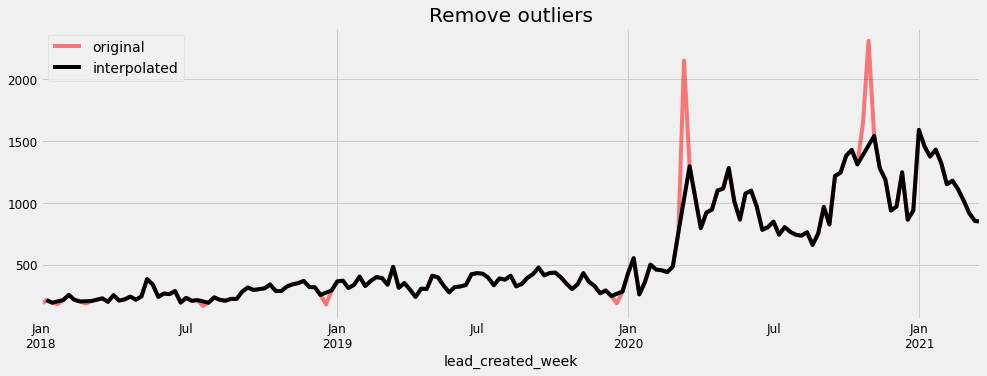

In [78]:
## outliers index position
outliers_index_pos = dtf_outliers[dtf_outliers["outlier"]==1].index## exclude outliers
ts_clean = remove_outliers(ts, outliers_idx=outliers_index_pos)

In [83]:
df = ts_clean.to_frame()

# Forecasting again w/out Outliers

In [84]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
                continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2668.719355931865
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2375.394059977674
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2189.567916075665
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2019.4565618753982
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2205.4231824141953
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2129.993583159097
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2027.5819586555358
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2015.973023207346
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2447.340633640913
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2187.1830771858995
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2057.6216630989147
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1890.8920688248836
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2088.0702699431113
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2002.6295809874232
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1913.8680769770676
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1889.9917138712915
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2060.9814883462914
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1925.001603301043

### Best model  --> ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1783.0272430399123


In [85]:
mod = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8100      0.087      9.315      0.000       0.640       0.980
ma.L1         -0.9447      0.060    -15.664      0.000      -1.063      -0.827
ma.S.L12      -0.8691      0.098     -8.913      0.000      -1.060      -0.678
sigma2      1.451e+04   1021.541     14.206      0.000    1.25e+04    1.65e+04


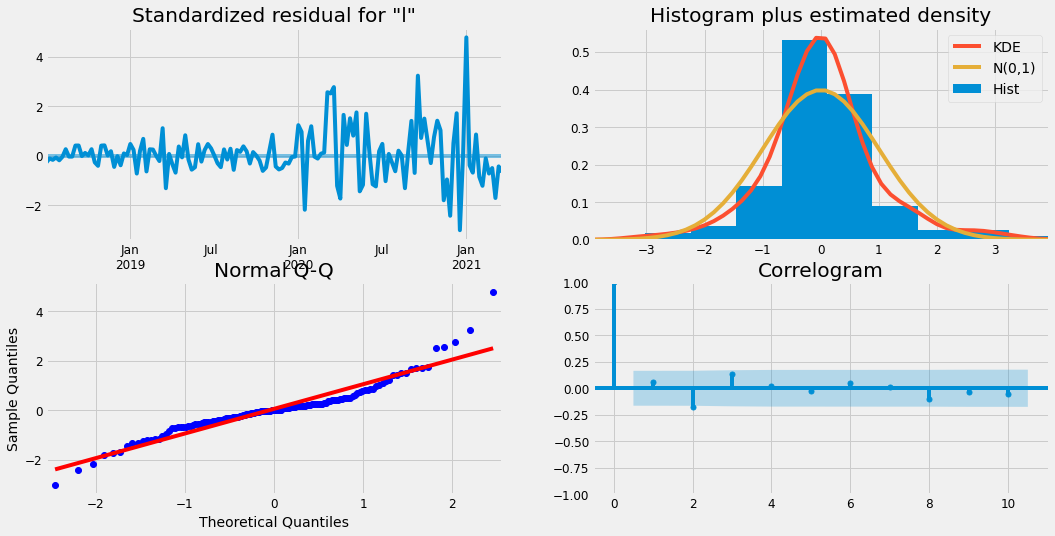

In [86]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

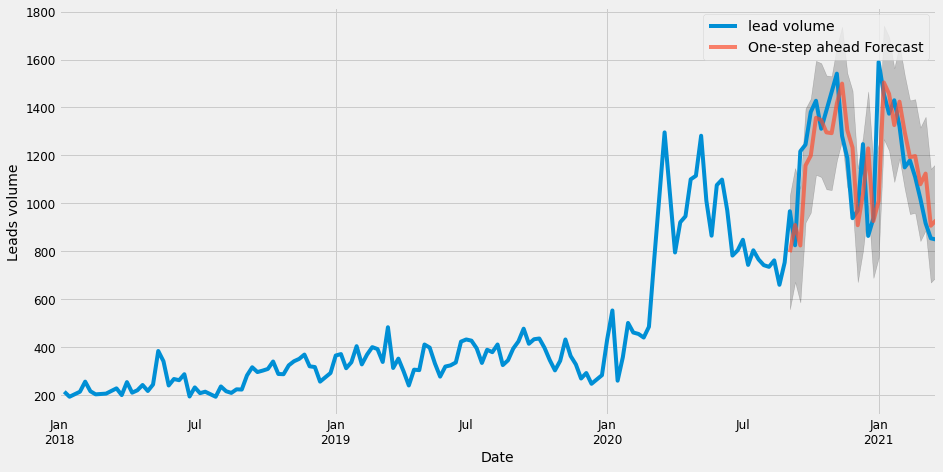

In [87]:
pred = results.get_prediction(start=pd.to_datetime('2020-09-07'), dynamic=False)
pred_ci = pred.conf_int()
ax = df['2018':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Leads volume')
plt.legend()
plt.show()

In [92]:
y_forecasted = pred.predicted_mean
y_truth = df['2020-09-07':]
mse = ((y_forecasted - y_truth['lead volume']) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 36975.46


In [93]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 192.29


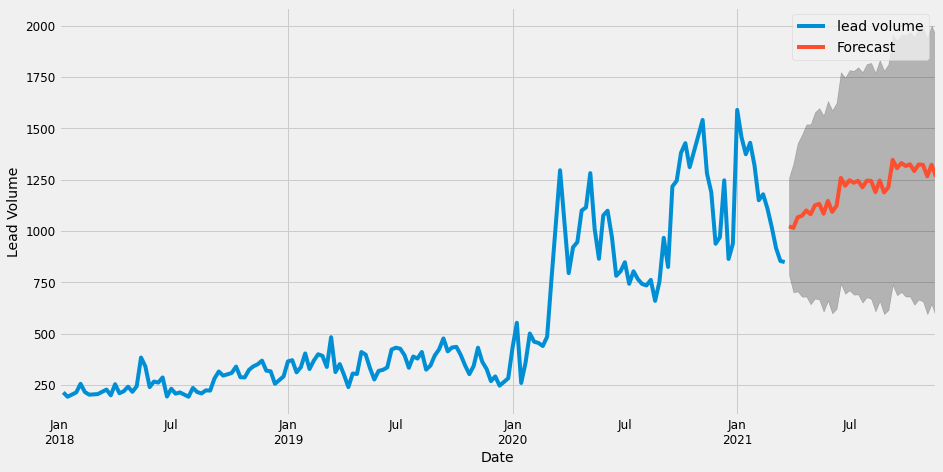

In [94]:
pred_uc = results.get_forecast(steps=35)
pred_ci = pred_uc.conf_int()
ax = df.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Lead Volume')
plt.legend()
plt.show()

In [97]:
pred_uc.predicted_mean.to_frame()

,predicted_mean
2021-03-29,1022.912316
2021-04-05,1015.234054
2021-04-12,1066.820148
2021-04-19,1074.635617
2021-04-26,1100.176424
2021-05-03,1081.507882
2021-05-10,1125.038012
2021-05-17,1132.503275
2021-05-24,1084.529503
2021-05-31,1146.828671
